# Project 2: Choose Your Own Ideas

In this project, you will work in teams to make use of skills you learrned in class to come up with an idea based upon data science technology. Your goal is to design a service/solution, and prepare a pitch for your idea.

Your team needs to decide a problem you would like to solve with a specific type of data, then design a data science approach to solve the problem.

This project is much more open ended.

**NOTE**
* Due Date: April 25, 2023, BEFORE 11:59PM EST
* Please download your code (notebook file as an ipynb file) and include it in your submission.
* There are always last minute issues submitting the project. DO NOT WAIT UNTIL THE LAST MINUTE!



# Problem: pick a data science problem that you plan to solve 
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the available data and data mining and machine learning solutions.

As a group, learn about the data science related business and research about the current markets: such as search, social media, advertisement, recommendation and so on. Pick one of the markets/domains for further consideration, find out a problem which you believe to be important in the market and design your solution. Define precisely in the report and briefly in the cells below, what is the business problem that your team wants to solve. Why the problem is important to solve? Why you believe you could make a big difference with data science technology.

Please briefly describe in the following cell: 

1) The problem you trying to solve:

2) Why the problem is important to solve?

3) What is your idea to solve the problem?

4) What differences you could make with your data science approach?

We are working on an image caption generator project using data collected from the coco website and the VGG16() model.

The problem we are trying to solve is to generate accurate and relevant captions for images. This is important because it can aid visually impaired individuals in understanding the content of images, improve search engine results, and enhance the overall user experience in applications that utilize images.

Our idea to solve the problem is to use a deep learning approach that combines a CNN to extract image features and an RNN with LSTM cells to generate captions based on those features. We also plan to use data augmentation techniques to increase the amount of training data and fine-tune the model to improve performance.

With our data science approach, we aim to improve the accuracy and relevance of the generated captions by fine-tuning the pre-trained VGG16 model, using transfer learning techniques, and implementing data augmentation techniques to increase the amount of training data. We also plan to use evaluation metrics such as BLEU score and human evaluation to validate the performance of the model. Additionally, we aim to make the model scalable and deployable for practical use in real-world applications.

In [ ]:
import os
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,Sequence
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import pickle
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from PIL import Image

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
MAX_SEQ_LENGTH = 50
EMBEDDING_DIM = 300
VOCAB_SIZE = 5000
BATCH_SIZE = 64
EPOCHS = 20

# Data Collection: 

The code is for collecting data from the Common Objects in Context (COCO) dataset which contains images and corresponding captions.

First, the annotations file is downloaded from the given URL and extracted. The annotations file contains information about the images and their associated captions.

Next, a dataframe is created by extracting the captions and image IDs from the annotations file. The top 10,000 images with the highest number of captions are selected by counting the frequency of each image ID and selecting the top 10,000 IDs.

Then, the images are downloaded from the COCO dataset using their respective URLs and saved in a newly created 'images' directory.

This code is an initial step in the image caption generator project and helps in collecting relevant data for training the model.


In [ ]:
url = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
response = requests.get(url)
with open('annotations_trainval2014.zip', 'wb') as f:
    f.write(response.content)

# extract annotations
!unzip annotations_trainval2014.zip

# load annotations file
with open('annotations/captions_train2014.json', 'r') as f:
    annotations = json.load(f)

Archive:  annotations_trainval2014.zip
  inflating: annotations/instances_train2014.json  
  inflating: annotations/instances_val2014.json  
  inflating: annotations/person_keypoints_train2014.json  
  inflating: annotations/person_keypoints_val2014.json  
  inflating: annotations/captions_train2014.json  
  inflating: annotations/captions_val2014.json  


In [ ]:
#cearting a dataframe of image_ids and their captions
captions = []
img_ids = []
for annot in annotations['annotations']:
    caption = annot['caption']
    captions.append(caption)
    img_ids.append(annot['image_id'])
df = pd.DataFrame({'image_id': img_ids, 'caption': captions})
df

,image_id,caption
0,318556,A very clean and well decorated empty bathroom
1,116100,A panoramic view of a kitchen and all of its a...
2,318556,A blue and white bathroom with butterfly theme...
3,116100,A panoramic photo of a kitchen and dining room
4,379340,A graffiti-ed stop sign across the street from...
...,...,...
414108,133071,a slice of bread is covered with a sour cream ...
414109,410182,A long plate hold some fries with some sliders...
414110,180285,Two women sit and pose with stuffed animals.
414111,133071,White Plate with a lot of guacamole and an ext...


In [ ]:
#length of unique image_ids(images)
len(df['image_id'].unique())

82783

In [ ]:
#extracting top 10,000 images with highest number of captions
counts = df['image_id'].value_counts()
top_image_ids = counts[:10000].index
df = df[df['image_id'].isin(top_image_ids)].reset_index(drop=True)

In [ ]:
#length of unique image_ids(images)
len(df['image_id'].unique())

10000

In [ ]:
df

,image_id,caption
0,318556,A very clean and well decorated empty bathroom
1,318556,A blue and white bathroom with butterfly theme...
2,318556,A bathroom with a border of butterflies and bl...
3,318556,An angled view of a beautifully decorated bath...
4,515040,Seagulls flying overhead while trucks sit in a...
...,...,...
50193,363273,A vase sitting on a table filled with flowers.
50194,363273,A vase in front of a yellow wall with flowers.
50195,363273,A vase with flowers on a black table in front ...
50196,363273,A blue striped vase of fake flowers on a black...


In [ ]:
def download_images(image_ids):
    for img_id in image_ids:
        img_url = f'http://images.cocodataset.org/train2014/COCO_train2014_{str(img_id).zfill(12)}.jpg'
        response = requests.get(img_url)
        if not os.path.exists('images'):
          os.makedirs('images')
        with open(f'images/{img_id}.jpg', 'wb') as f:
            f.write(response.content)

download_images(df['image_id'].unique())

# Data Exploration: Exploring the Dataset



We need to get an idea of the images and their corresponding captions that we'll be working with in the image caption generator project. To do so, we can display some sample images along with their captions. We use the 
matplotlib library to plot them with their captions.

In [ ]:
def display(img_id):
  # open image
  img_path = os.path.join('images/', f"{img_id}.jpg")
  img = Image.open(img_path)

  # plot image and captions
  fig, ax = plt.subplots()
  ax.imshow(img)
  ax.axis('off')
  ax.set_title('Captions for Image ID '+str(img_id))

  plt.show()
  rows = df.loc[df['image_id'] == img_id]

# Iterate over the rows and print the captions
  for index, row in rows.iterrows():
      print(row['caption'])

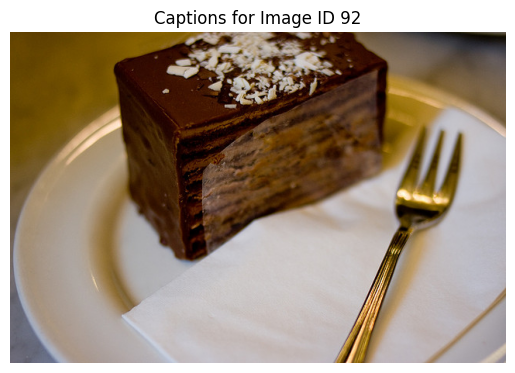

A white plate with a brownie and white frosting.
A piece of chocolate cake on top of a white plate.
a chocolate cake and a fork ready to be eat
A chocolate desert on a plate with a fork. 
A piece of chocolate dessert on a plate with a napkin and a fork.


In [ ]:
display(92)

Before building the image caption generator model, we first need to extract the features from the images using a pre-trained model. In this case, we use the VGG16 model that has been pre-trained on the ImageNet dataset for object recognition. To check the architecture and summary of the VGG16 model, we call the summary() method of the Keras VGG16 model.

In [ ]:
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Extracting Features from Images:
To extract the features from the images, we need to pass the images through the VGG16 model and use the output from the last convolutional layer. We can use the predict() method of the VGG16 model to extract the features for a given image.

In [ ]:
features = {}
directory = 'images'

for img_name in tqdm(os.listdir(directory)):
    if img_name.endswith('.jpg'):  # check if file is an image
        # load the image from file
        img_path = directory + '/' + img_name
        image = load_img(img_path, target_size=(224, 224))
        # convert image pixels to numpy array
        image = img_to_array(image)
        # reshape data for model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # preprocess image for vgg
        image = preprocess_input(image)
        # extract features
        feature = model.predict(image, verbose=0)
        # get image ID
        image_id = img_name.split('.')[0]
        # store feature
        features[image_id] = feature


  0%|          | 0/10000 [00:00<?, ?it/s]

Now, we will save all the features in a pickle file so that it can be accessed quickly 

In [ ]:
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)

In [ ]:
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)


We create a mapping of each image with its corresponding captions. We create a mapping between the image features and their captions by matching the image_ids in the DataFrame with the features extracted from the VGG16 model.

In [ ]:
mapping = {}

for index, row in df.iterrows():
    img_id = str(row['image_id'])
    caption = row['caption']
    if img_id in mapping:
        mapping[img_id].append(caption)
    else:
        mapping[img_id] = [caption]


In [ ]:
mapping['570416']

['Two pictures of a skier sliding down a ramp in the snow.  ',
 'A man snowboarding on a ledge of some sort.',
 'a person riding a snow board on a railing',
 'A snow skier is in mid air on top of a mountain.',
 'Two pictures of snow boarders on a raised stunt feature.']

The function clean(mapping) is a data preprocessing step that takes in a mapping of image file names to their respective captions, and performs several cleaning steps on each caption.

The function loops over each caption in the mapping and performs the following preprocessing steps:

    Convert all letters to lowercase
    Remove any non-alphabetic characters using a regular expression
    Remove any additional white space characters
    Add special start and end tags to the caption to indicate the beginning and end of a sentence.

This process helps to standardize the captions and remove any unwanted characters that may negatively impact the model's training.

The function modifies the original mapping dictionary in place, replacing each caption with the cleaned version.

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'captionstarts ' + " ".join([word for word in caption.split() if len(word)>1]) + ' captionends'
            captions[i] = caption

clean(mapping)

In [ ]:
mapping['570416']

['captionstarts two pictures of skier sliding down ramp in the snow. captionends',
 'captionstarts man snowboarding on ledge of some sort. captionends',
 'captionstarts person riding snow board on railing captionends',
 'captionstarts snow skier is in mid air on top of mountain. captionends',
 'captionstarts two pictures of snow boarders on raised stunt feature. captionends']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        
len(all_captions)

50198

Now we will prepare the tokenization of all the cleaned captions using the Tokenizer() class from Keras. The fit_on_texts() method of the tokenizer is used to fit the tokenizer on all the cleaned captions. This method creates the vocabulary of words from the captions and assigns a unique integer index to each word based on its frequency. The word_index attribute of the tokenizer contains this mapping of words to integer indices.

len(tokenizer.word_index) + 1 is used to calculate the vocabulary size, where the +1 is for the special token that will be used to mark the end of the captions during training. The resulting vocabulary size is the total number of unique words in the captions, including the special token.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8377

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

41

Now we will split the list of image IDs into two sets, a training set and a test set, using a 90/10 split.

image_ids is a list containing all the image IDs, and split is the index at which the split will occur. The first 90% of the image IDs are assigned to the train list, while the remaining 10% are assigned to the test list.

The model is trained on the training data, and the test data is used to evaluate the model's performance on unseen data. The split ensures that the model is not overfitting to the training data, and that its performance can be generalized to new data.

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

# Data Analysis: you can use different methods to solve the problem you proposed, and find out the best solution.

Now we will implement a deep learning model for image captioning using a combination of Convolutional Neural Networks (CNN) and Recurrent Neural Networks (RNN). The model is trained on a dataset of images and their corresponding captions, and can generate captions for new images.

Now we will create a generator function to generate data in batches for the model training. The generator takes in the image IDs, the mapping of image IDs to their respective captions, image features extracted using a pre-trained CNN model, a tokenizer to convert text into numerical sequences, the maximum length of the caption sequences, the size of the vocabulary, and the batch size. The generator loops over the images and their captions, preprocesses the text by encoding and padding the sequences, and yields the image features, input sequences, and output sequences as numpy arrays in batches.

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

Now we will define the encoder-decoder model for image captioning. The model consists of two parts: an encoder that processes the image features and a decoder that processes the caption sequences. The encoder takes in the image features, applies dropout regularization, and passes the output through a fully connected layer to produce a feature vector. The decoder takes in the caption sequences, applies an embedding layer, and passes the output through a LSTM layer to produce a sequence vector. The sequence vector is then concatenated with the feature vector and passed through another fully connected layer to produce a final output. The final output is passed through a softmax activation function to produce a probability distribution over the vocabulary, representing the likelihood of each word in the vocabulary to be the next word in the caption sequence.

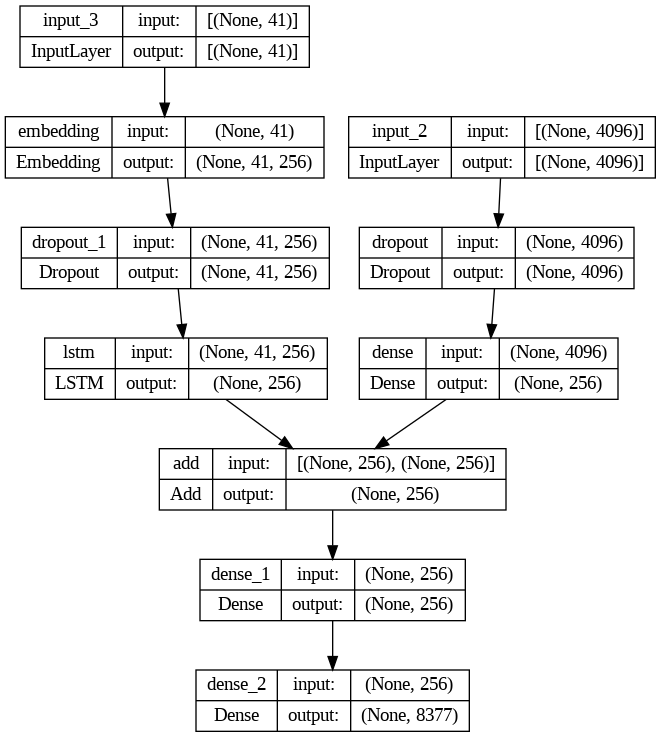

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

The model is now trained on the training data using the generator and the fit() method. The training process involves iterating over a fixed number of epochs and updating the model weights based on the loss between the predicted and actual output sequences.

In [ ]:
from re import L
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size
loss = []


for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    l = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss.append(l)
    print("Loss :",l)

    

281/281 [==============================] - 164s 567ms/step - loss: 4.7727
Loss : <keras.callbacks.History object at 0x7f902064d0a0>
281/281 [==============================] - 156s 555ms/step - loss: 3.7109
Loss : <keras.callbacks.History object at 0x7f9020146490>
281/281 [==============================] - 157s 558ms/step - loss: 3.3054
Loss : <keras.callbacks.History object at 0x7f9081d498b0>
281/281 [==============================] - 156s 553ms/step - loss: 3.0605
Loss : <keras.callbacks.History object at 0x7f9081996f40>
281/281 [==============================] - 156s 556ms/step - loss: 2.8817
Loss : <keras.callbacks.History object at 0x7f9081996d30>
281/281 [==============================] - 155s 550ms/step - loss: 2.7428
Loss : <keras.callbacks.History object at 0x7f90819b3910>
281/281 [==============================] - 155s 552ms/step - loss: 2.6351
Loss : <keras.callbacks.History object at 0x7f90281ef4f0>
281/281 [==============================] - 157s 558ms/step - loss: 2.5530
Lo

In [ ]:
# save the model
model.save('/best_model.h5')

Finally, we have two utility functions for predicting captions for new images. The first function converts an integer index to its corresponding word in the vocabulary using the tokenizer. The second function takes in an image, the trained model, the tokenizer, and the maximum length of the caption sequences, and generates a caption for the image by iteratively predicting the next word in the sequence until either the end tag or the maximum length is reached. The function returns the generated caption.

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'captionstarts'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'captionends':
            break
      
    return in_text

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


Now we will evaluate the performance of the image captioning model using BLEU (Bilingual Evaluation Understudy) score. BLEU is a metric commonly used to evaluate the quality of generated sentences by comparing them to reference sentences.

The corpus_bleu function from the nltk.translate.bleu_score library is used to calculate the BLEU score between the predicted captions and the actual captions for the test dataset.

The actual and predicted lists are initialized to empty lists. Then, for each image in the test dataset, the actual captions are obtained from the mapping dictionary and the predicted caption is generated using the predict_caption function. The actual captions are split into words and stored in the actual_captions list. The predicted caption is also split into words and stored in the y_pred list. The actual_captions and y_pred lists are appended to the actual and predicted lists, respectively.

Finally, the corpus_bleu function is called twice with different weights to calculate the BLEU-1 and BLEU-2 scores. The weights parameter specifies the weight given to each n-gram precision score. For example, (1.0, 0, 0, 0) gives equal weight to the unigram precision, (0.5, 0.5, 0, 0) gives equal weight to the unigram and bigram precision, and so on. The BLEU-1 score is the unigram precision, while the BLEU-2 score is the combination of unigram and bigram precision.

The resulting BLEU-1 and BLEU-2 scores are printed to the console.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate=ing the BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1: 0.625592
BLEU-2: 0.374556


Now we will define a function generate_caption that takes an image_name as input and generates and prints the actual captions and predicted caption for that image using the trained model. It also displays the image using matplotlib.

Here's a brief description of the input parameters and the functionality of the function:

Input:

    image_name: A string representing the name of the image file (e.g., "example.jpg")

Functionality:

    Extracts the image ID from the image_name by removing the file extension.
    Loads the image from the images folder using the Image.open method from the PIL library.
    Gets the actual captions for the image from the mapping dictionary.
    Prints the actual captions.
    Generates the predicted caption for the image using the predict_caption function.
    Prints the predicted caption.
    Displays the image using the plt.imshow method from matplotlib.

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join("images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
captionstarts racks of cupcakes with cake on the top. captionends
captionstarts many colorful cupcakes are stacked below similar cake. captionends
captionstarts cake with multiple platforms with cupcakes on them captionends
captionstarts very well constructed mario cake with cupcakes. captionends
captionstarts cake and several cupcakes are being displayed. captionends
--------------------Predicted--------------------
captionstarts child's room with cakes and cupcakes on it captionends


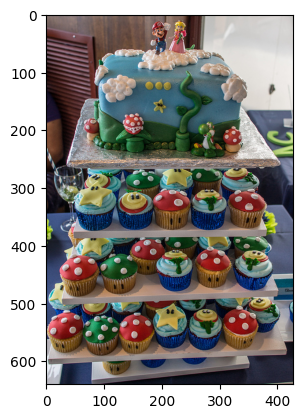

In [ ]:
generate_caption("100378.jpg")

Now we will generate a caption for an image using a pre-trained VGG16 model and a pre-trained captioning model.

First, the VGG16 model is loaded using the VGG16() function from the Keras library.
    
Then, the model is restructured to remove the last layer using the Model() function from Keras. This is done by specifying the inputs to the model and the outputs from the second last layer using vgg_model.inputs and vgg_model.layers[-2].output, respectively.
    
An image is loaded using the load_img() function from the Keras library. The target size is specified as (224, 224) which is the input size expected by the VGG16 model.
    
The image pixels are converted to a numpy array using the img_to_array() function from Keras.
    
The image is reshaped to have a batch size of 1 using the reshape() function from numpy.
    
The image is preprocessed using the preprocess_input() function from Keras. This function applies mean subtraction to the image data to ensure that the pixel values are centered around zero.
    
The features of the image are extracted using the vgg_model.predict() function. This function takes the preprocessed image as input and returns the output from the second last layer of the VGG16 model.
    
Finally, the predict_caption() function is called to generate a caption for the image. The function takes as input the pre-trained captioning model, the extracted features of the image, the tokenizer used to convert words to integers, and the maximum length of the caption. The function returns a string representing the predicted caption for the image.

'captionstarts man walking on the beach with surfboard captionends'

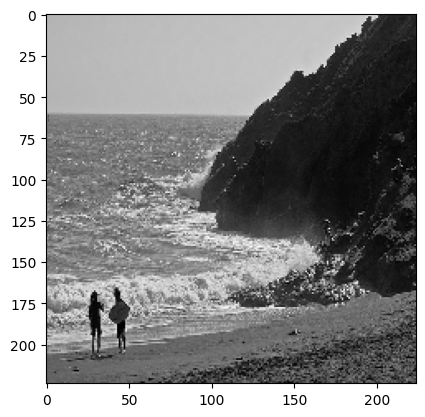

In [ ]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

image_path = '/content/images/113393.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
plt.imshow(image)
# converting image pixels to numpy array
image = img_to_array(image)
# reshaping the data 
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocessing the image
image = preprocess_input(image)
# extracting features
feature = vgg_model.predict(image, verbose=0)
# predicting the output
predict_caption(model, feature, tokenizer, max_length)


# Done

All set! 

**What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. 

* **PDF Report**: please prepare a final report in the PDF form which should be at least 5 pages. The report should includes:

  * What is you motivation?

  * What data you collected?

  * How does this data support your product idea?

  * How did you analyse the data?

  * What did you find in the data?

  * (please include figures or tables in the report, but no source code)
  
* **PPT Slides**: please prepare PPT slides to present about the project. Each team present their case studies in class for 10 minutes. **Story-telling** is important, the slides should include:

  1. Motivation about the data collection, why the topic is interesting to you.

  2. Communicating Results (figure/table)

  3. Story telling (How all the parts (data, analysis, result) fit together as a story?)

Please compress all the files in a zipped file.

        
**Note: Each team only needs to submit one submission**